### Block neural autoregressive flow

Here we show how we can use [block neural autoregressive flows](https://arxiv.org/abs/1904.04676) for (in this case conditional) density estimation.

The model is as follows:
$$u_1 \sim \text{Uniform}(0,5)$$
$$u_2 \sim \text{Uniform}(0,5)$$

$$x_i \sim \text{Uniform}(0, u_i), \quad \text{for}\ i\ \text{in}\ 1,2$$

We will try to infer the conditional distribution $p(x|u)$ using samples from the model.


In [5]:
from jax import random
import jax.numpy as jnp
import numpy as onp
from flowjax.flows import BlockNeuralAutoregressiveFlow
from flowjax.distributions import Normal
from flowjax.train_utils import train_flow
import matplotlib.pyplot as plt

In [6]:
key, x_key, cond_key = random.split(random.PRNGKey(7), 3)
u = random.uniform(cond_key, (10000, 2), minval=0, maxval=5)
x = random.uniform(x_key, shape=u.shape, maxval=u)
assert jnp.all(x < u)

In [7]:
key, subkey = random.split(random.PRNGKey(0))

flow = BlockNeuralAutoregressiveFlow(
    key=subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    cond_dim=u.shape[1],
    nn_depth=4,
    nn_block_dim=8,
)

key, subkey = random.split(key)
flow, losses = train_flow(subkey, flow, x, u, learning_rate=1e-2)

 80%|████████  | 40/50 [00:19<00:04,  2.05it/s, train=1.28, val=1.34 (Max patience reached)]


### Visualize learned conditional density
Let's condition on $u=[1,3]'$, in which case we expect $x_1 \sim \text{Uniform}(0, 1)$ and $x_2 \sim \text{Uniform}(0, 3)$

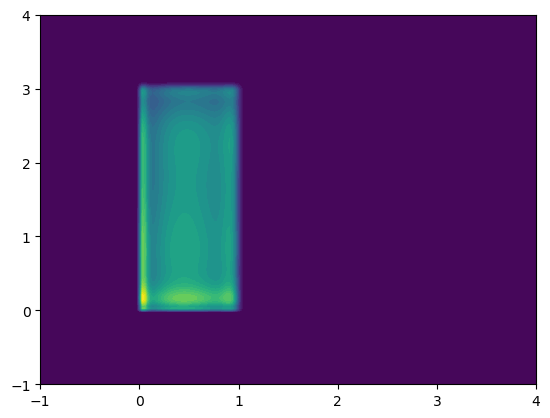

In [8]:
resolution = 200
test_u = jnp.array([1.0, 3])
xline = jnp.linspace(-1, 4, resolution)
yline = jnp.linspace(-1, 4, resolution)
xgrid, ygrid = jnp.meshgrid(xline, yline)
xyinput = jnp.column_stack((xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)))
zgrid = jnp.exp(flow.log_prob(xyinput, test_u).reshape(resolution, resolution))

grids = [onp.array(g) for g in [xgrid, ygrid, zgrid]]
plt.contourf(*grids, levels=40)
plt.show()